In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass

import tensorflow as tf

import numpy as np

tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

TensorFlow 1.x selected.


In [ ]:
!pip install git+https://github.com/Jakondak/differential-privacy-library.git

  Cloning https://github.com/Jakondak/differential-privacy-library.git to /tmp/pip-req-build-zs5c57kq
  Running command git clone -q https://github.com/Jakondak/differential-privacy-library.git /tmp/pip-req-build-zs5c57kq
  Created wheel for diffprivlib: filename=diffprivlib-0.2.0-cp36-none-any.whl size=113324 sha256=b6c4ee897c3cc288678ec4bad972d6d0948c5d9271be39dd98db81fa88877c39
  Stored in directory: /tmp/pip-ephem-wheel-cache-wmpdkq2i/wheels/80/34/51/2143cfa48406e75a606ad27411f5dc9429a5c023627e395c1a
Successfully built diffprivlib


In [ ]:
import pandas as pd
import numpy as np
import time
import scipy
import diffprivlib.models as models
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
train, test = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
X_train_cf, y_train_cf = train
X_test_cf, y_test_cf = test

### GaussianNB by IBM

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X_train = X_train_cf.reshape(X_train_cf.shape[0], 3072, )
X_test = X_test_cf.reshape(X_test_cf.shape[0], 3072, )
y_train = y_train_cf
y_test = y_test_cf

In [ ]:
epsilons = np.logspace(-2, 2, 11)
deltas = np.linspace(0,1,11)
accuracy_df_gaus = list()
epsilons_df_gaus = list()
delta_df_gaus = list()

for epsilon in epsilons:
    for delta in deltas:
        clf = models.GaussianNB(epsilon=epsilon, delta=delta)
        clf.fit(X_train, y_train)
    
        accuracy_df_gaus.append(accuracy_score(y_test, clf.predict(X_test)))
        epsilons_df_gaus.append(round(epsilon, 2))
        delta_df_gaus.append(round(delta, 2))

In [ ]:
gausian_df = pd.DataFrame(data=np.column_stack([accuracy_df_gaus, epsilons_df_gaus, delta_df_gaus]), columns=['accuracy', 'epsilon', 'delta'])
gausian_df = gausian_df.pivot('epsilon', 'delta', 'accuracy')
ax = sns.heatmap(gausian_df, cbar_kws={'label': 'accuracy'})

NameError: ignored

### Linear regression by IBM

In [ ]:
from sklearn.linear_model import LinearRegression as sk_LinearRegression
from sklearn.metrics import r2_score

regr = sk_LinearRegression()
regr.fit(X_train, y_train)
baseline = r2_score(y_test, regr.predict(X_test))
print("Non-private baseline: %.2f" % baseline)

Non-private baseline: 0.03


In [ ]:
%%time
epsilons = np.logspace(-2, 2, 11)
deltas = np.linspace(0,1,11)

accuracy_df_lin_reg = list()
epsilons_df_lin_reg = list()
delta_df_lin_reg = list()

for epsilon in epsilons:
    for delta in deltas:
        clf = models.LinearRegression(epsilon=epsilon, delta=delta)
        clf.fit(X_train, y_train)
    
        accuracy_df_lin_reg.append(accuracy_score(y_test, np.round(clf.predict(X_test), decimals=0)))
        epsilons_df_lin_reg.append(round(epsilon, 2))
        delta_df_lin_reg.append(round(delta, 2))

CPU times: user 1h 53min 34s, sys: 3min 29s, total: 1h 57min 4s
Wall time: 1h 1min 50s


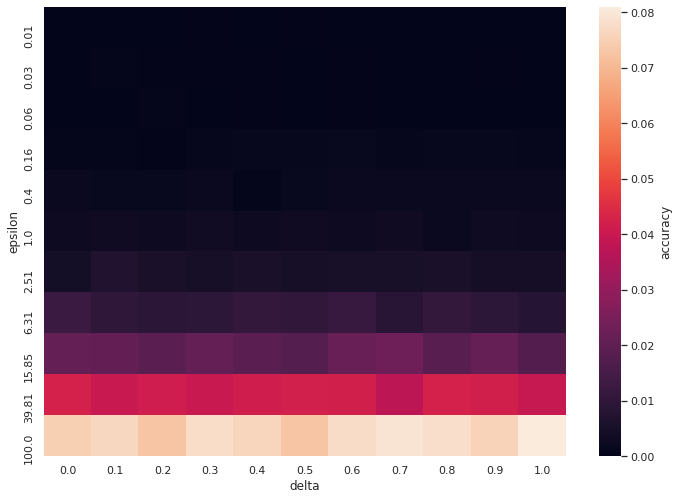

In [ ]:
lin_reg_df = pd.DataFrame(data=np.column_stack([accuracy_df_lin_reg, epsilons_df_lin_reg, delta_df_lin_reg]), columns=['accuracy', 'epsilon', 'delta'])
lin_reg_df = lin_reg_df.pivot('epsilon', 'delta', 'accuracy')
ax = sns.heatmap(lin_reg_df, cbar_kws={'label': 'accuracy'})

### Logistic regression by IBM

In [ ]:
#Scaler

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import diffprivlib.models as dp

lr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(solver="lbfgs"))
])

#### LR wo DP

In [ ]:
lr.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
from sklearn.metrics import accuracy_score

print("Non-private test accuracy: %.2f%%" % (accuracy_score(y_test, lr.predict(X_test)) * 100))

Non-private test accuracy: 40.63%


#### LR with DP

In [ ]:
dp_lr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', dp.LogisticRegression())
])

dp_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('clf',
                 LogisticRegression(C=1.0, data_norm=54.9156786783691,
                                    delta=0.0, epsilon=1.0, fit_intercept=True,
                                    max_iter=100, n_jobs=None, tol=0.0001,
                                    verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
dp_lr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', dp.LogisticRegression(epsilon=float("inf"), data_norm=2))
])

dp_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('clf',
                 LogisticRegression(C=1.0, data_norm=2, delta=0.0, epsilon=inf,
                                    fit_intercept=True, max_iter=100,
                                    n_jobs=None, tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
print("Agreement between non-private and differentially private (epsilon=inf) classifiers: %.2f%%" %  
      (accuracy_score(lr.predict(X_test), dp_lr.predict(X_test)) * 100))

Agreement between non-private and differentially private (epsilon=inf) classifiers: 74.84%


In [ ]:
epsilons = np.logspace(-2, 2, 11)
deltas = np.linspace(0,1,11)
#bounds = [(4.3, 7.9), (2.0, 4.4), (1.1, 6.9), (0.1, 2.5)]
accuracy_df_log = list()
epsilons_df_log= list()
delta_df_log = list()

for epsilon in epsilons:
    for delta in deltas:
        dp_lr.set_params(clf__epsilon=epsilon, clf__delta=delta).fit(X_train, y_train)
    
        accuracy_df_log.append(accuracy_score(y_test, dp_lr.predict(X_test)))
        epsilons_df_log.append(round(epsilon, 2))
        delta_df_log.append(round(delta, 2))

#plt.semilogx(epsilons, accuracy)
#plt.title("Differentially private Naive Bayes accuracy")
#plt.xlabel("epsilon")
#plt.ylabel("Accuracy")
#plt.show()

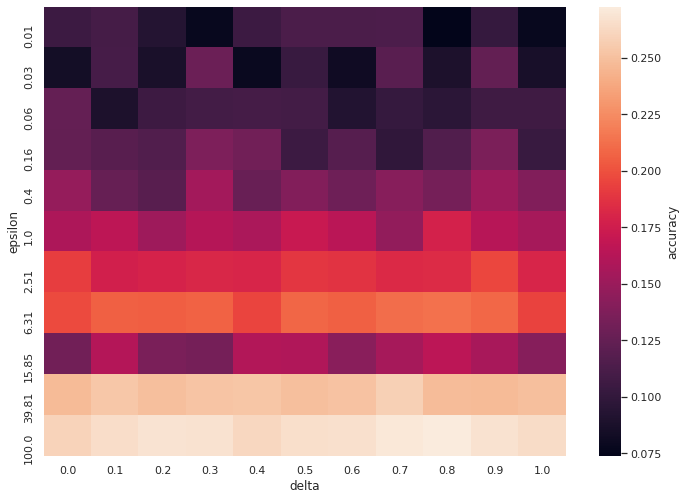

In [ ]:
log_df = pd.DataFrame(data=np.column_stack([accuracy_df_log, epsilons_df_log, delta_df_log]), columns=['accuracy', 'epsilon', 'delta'])
log_df = log_df.pivot('epsilon', 'delta', 'accuracy')
ax = sns.heatmap(log_df, cbar_kws={'label': 'accuracy'})